# Differential abundance analysis with Milo in python

**Author:** Emma Dann <br>
**Date:** 03/08/2022

In this vignette we will demonstrate how to use the R package [`miloR`](https://github.com/MikeDMorgan/miloR) for differential abundance analysis on [`anndata`](https://github.com/theislab/anndata) objects using the [`anndata2ri`](https://github.com/theislab/anndata2ri) package to allow conversion between `anndata` and `SingleCellExperiment` objects, and viceversa. The code from the Theis lab [single cell tutorial](https://github.com/theislab/single-cell-tutorial/blob/master/latest_notebook/Case-study_Mouse-intestinal-epithelium_1906.ipynb) was really useful to make python-R interoperability work.


**There are more options to integrate Milo in your scverse-based single-cell analysis!**
- You can use the python implementation [`milopy`](https://github.com/emdann/milopy) (see [vignette](https://nbviewer.org/github/emdann/milopy/blob/master/notebooks/milopy_example.ipynb))
- You can save your anndata object as H5AD, load it in R as `SingleCellExperiment` using the [`zellconverter` package](https://theislab.github.io/zellkonverter/), and then follow the `miloR` vignettes from there (see the [Scanpy in R vignette](https://theislab.github.io/scanpy-in-R/#content) to see how you can use your favourite scanpy functionality in an R session)



## Preparations

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(8,8) #rescale figures
sc.settings.verbosity = 3

### r2py set-up
First of all we need to install `anndata2ri`. In a terminal run:
```
pip install anndata2ri
# or
conda install -c bioconda anndata2ri
```

In [2]:
pip install anndata2ri

Note: you may need to restart the kernel to use updated packages.


Please refer to the [README](https://github.com/theislab/anndata2ri/blob/master/README.rst) for troubleshooting

In [3]:
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging

In [4]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

Activate the anndata2ri conversion between SingleCellExperiment and AnnData

In [5]:
anndata2ri.activate()

/tmp/ipykernel_333419/4016445965.py:1: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


Loading the `rpy2` extension enables cell magic to be used. This runs R code in jupyter notebook cells.

In [6]:
%load_ext rpy2.ipython

### Milo set-up

We need to install the R package from github. 

In [7]:
%%R
devtools::install_github("MarioniLab/miloR")

These packages have more recent versions available.
It is recommended to update all of them.
Which would you like to update?

1: All                                           
2: CRAN packages only                            
3: None                                          
4: labeling     (0.4.2      -> 0.4.3     ) [CRAN]
5: S4Arrays     (1.0.5      -> 1.0.6     ) [CRAN]
6: GenomeInfoDb (1.36.1     -> 1.36.2    ) [CRAN]
7: RcppArmad... (0.12.6.1.0 -> 0.12.6.3.0) [CRAN]

Enter one or more numbers, or an empty line to skip updates: 1
labeling     (0.4.2      -> 0.4.3     ) [CRAN]
S4Arrays     (1.0.5      -> 1.0.6     ) [CRAN]
GenomeInfoDb (1.36.1     -> 1.36.2    ) [CRAN]
RcppArmad... (0.12.6.1.0 -> 0.12.6.3.0) [CRAN]


* installing *source* package ‘labeling’ ...
** package ‘labeling’ successfully unpacked and MD5 sums checked
** using staged installation
** R
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (labeling)
* installing *source* package ‘S4Arrays’ ...
** using staged installation
** libs
using C compiler: ‘gcc (crosstool-NG 1.24.0.133_b0863d8_dirty) 7.5.0’


gcc -I"/usr/share/R/include" -DNDEBUG  -I'/home/ubuntu/R/x86_64-pc-linux-gnu-library/4.3/S4Vectors/include'     -fpic  -g -O2 -ffile-prefix-map=/build/r-base-MHXHhT/r-base-4.3.1=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c R_init_S4Arrays.c -o R_init_S4Arrays.o


gcc: error: unrecognized command line option '-ffile-prefix-map=/build/r-base-MHXHhT/r-base-4.3.1=.'
make: *** [/usr/lib/R/etc/Makeconf:191: R_init_S4Arrays.o] Error 1
ERROR: compilation failed for package ‘S4Arrays’
* removing ‘/home/ubuntu/R/x86_64-pc-linux-gnu-library/4.3/S4Arrays’
* restoring previous ‘/home/ubuntu/R/x86_64-pc-linux-gnu-library/4.3/S4Arrays’
* installing *source* package ‘GenomeInfoDb’ ...
** using staged installation
** R
** inst
** byte-compile and prepare package for lazy loading
** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (GenomeInfoDb)
* installing *source* package ‘RcppArmadillo’ ...
** package ‘RcppArmadillo’ successfully unpacked and MD5 sums checked
** using staged installation


checking whether the C++ compiler works... no


configure: error: in `/tmp/RtmpcfyaHr/R.INSTALL5174c3de6b86d/RcppArmadillo':
configure: error: C++ compiler cannot create executables
See `config.log' for more details
ERROR: configuration failed for package ‘RcppArmadillo’
* removing ‘/home/ubuntu/R/x86_64-pc-linux-gnu-library/4.3/RcppArmadillo’
* restoring previous ‘/home/ubuntu/R/x86_64-pc-linux-gnu-library/4.3/RcppArmadillo’


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpjwwHgV/remotes5166b231e1bd0/MarioniLab-miloR-1ecd56f/DESCRIPTION’ ... OK
* preparing ‘miloR’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* looking to see if a ‘data/datalist’ file should be added
* building ‘miloR_1.9.1.tar.gz’



* installing *source* package ‘miloR’ ...
** using staged installation
** R
** data
** byte-compile and prepare package for lazy loading


Creating a new generic function for ‘graph’ in package ‘miloR’


** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (miloR)


Installing 4 packages: labeling, S4Arrays, GenomeInfoDb, RcppArmadillo
Installing packages into ‘/home/ubuntu/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘lib’ is unspecified)
trying URL 'https://cloud.r-project.org/src/contrib/labeling_0.4.3.tar.gz'
Content type 'application/x-gzip' length 10167 bytes
downloaded 10167 bytes

trying URL 'https://bioconductor.org/packages/3.17/bioc/src/contrib/S4Arrays_1.0.6.tar.gz'
Content type 'application/x-gzip' length 281091 bytes (274 KB)
downloaded 274 KB

trying URL 'https://bioconductor.org/packages/3.17/bioc/src/contrib/GenomeInfoDb_1.36.2.tar.gz'
Content type 'application/x-gzip' length 3579396 bytes (3.4 MB)
downloaded 3.4 MB

trying URL 'https://cloud.r-project.org/src/contrib/RcppArmadillo_0.12.6.3.0.tar.gz'
Content type 'application/x-gzip' length 1400611 bytes (1.3 MB)
downloaded 1.3 MB


The downloaded source packages are in
	‘/tmp/RtmpjwwHgV/downloaded_packages’
Installing package into ‘/home/ubuntu/R/x86_64-pc-linux-gnu-library/4.3’
(as ‘l

In [8]:
%%R
library(miloR)
library(igraph)

Loading required package: edgeR
Loading required package: limma

Attaching package: ‘igraph’

The following object is masked from ‘package:miloR’:

    graph

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [9]:
%%R
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 22.04.3 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.10.0 
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.10.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] tools     stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
[1] igraph_1.5.1 miloR_1.9.1  edgeR_3.42.4 limma_3.56.2

loaded via a namespace (and not attached):
  [1] bitops_1.0-7                gridExtra_2.3              
  [3] remotes_2.4.2.1             rlang_1.1.1                
  [5] magrittr_2.0.3              m

## Load and prepare example dataset

For this vignette I will use the mouse gastrulation data from [Pijuan-Sala et al. 2019](https://www.nature.com/articles/s41586-019-0933-9). 

The dataset is available in AnnData format through the `scvelo` package https://scvelo.readthedocs.io/scvelo.datasets.gastrulation/#scvelo.datasets.gastrulation
<!-- The dataset can be downloaded as a `SingleCellExperiment` object from the [`MouseGastrulationData`](https://bioconductor.org/packages/3.12/data/experiment/html/MouseGastrulationData.html) package on Bioconductor. I will download just a subset of samples to make the vignette faster, 6 samples at stage E7 and 6 samples at stage E7.5.

We will load this data and convert it to an `anndata` for the sake of our vignette. The only thing you need to do is to add `-o <object-name>` to the end of the R magic line in your jupyter notebook. -->

In [10]:
pip install scvelo

Note: you may need to restart the kernel to use updated packages.


In [11]:
from scvelo.datasets import gastrulation
adata = gastrulation()

In [12]:
# %%R -o embryo_data 
# # BiocManager::install("MouseGastrulationData")
# library(MouseGastrulationData)        

# embryo_data = EmbryoAtlasData(samples = c(2,  3,  4,  6, 10, 14, 15, 19, 20, 30, 31, 32))

This dataset was batch corrected using MNN and now contains reduced dimensions saved in the `obsm` slot as `X_pca`.

In [13]:
adata

AnnData object with n_obs × n_vars = 89267 × 53801
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

To speed up this vignette, I subset to samples between stage E7 and E8.

In [14]:
adata = adata[adata.obs['stage'].isin(['E7', 'E7.25', "E7.5", 'E7.75'])].copy()

Now we can use scanpy to build the KNN graph and embedding

computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:31)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


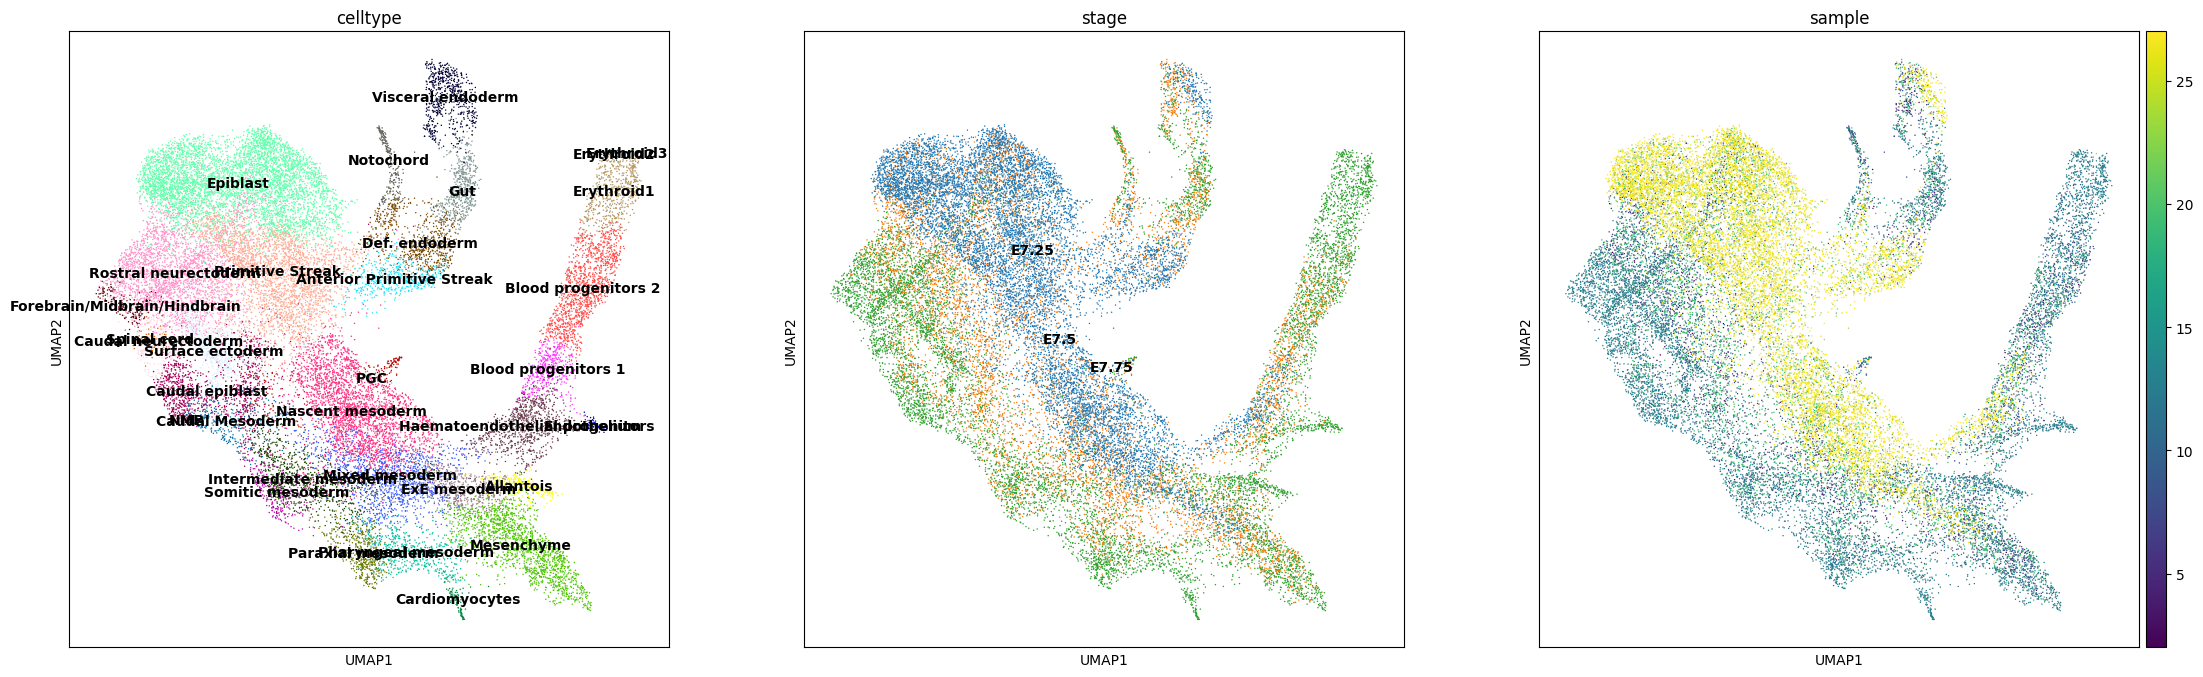

In [15]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=30)

sc.tl.umap(adata)

sc.pl.umap(adata, color=["celltype","stage", "sample"], legend_loc="on data")

This is probably what your anndata looks like when you start thinking about differential abundance analysis. In the next section we will see how to use `r2py` and `anndata2ri` functionality to integrate _Milo_ differential abudance analysis in your python workflow.

## Differential abundance (DA) analysis with Milo

#### Make Milo object

To start with, we have to convert our anndata object back into a SingleCellExperiment. The `anndata2ri` converter doesn't seem to like converting anndata objects storing the KNN graph in the `adata.obsp` slot, probably because there is no dedicated slot in the `SingleCellExperiment` object. Because of this, we will first make a copy of our `anndata` without KNN graph for conversion.

In [16]:
adata_no_knn = adata.copy()
adata_no_knn.obsp = None
adata_no_knn.uns.pop("neighbors")
adata_no_knn

AnnData object with n_obs × n_vars = 27863 × 53801
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'umap', 'celltype_colors', 'stage_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

This can be converted to a `SingleCellExperiment` using R magic again

In [17]:
%%R -i adata_no_knn
adata_no_knn

class: SingleCellExperiment 
dim: 53801 27863 
metadata(3): umap celltype_colors stage_colors
assays(3): X spliced unspliced
rownames(53801): Xkr4 Gm37180 ... Gm47283 Gm21742
rowData names(5): Accession Chromosome End Start Strand
colnames(27863): cell_362 cell_363 ... cell_91078 cell_91079
colData names(28): barcode sample ... endo_gutCluster
  cell_velocyto_loom
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):


In addition: Warning messages:
1: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
2: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
3: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages
4: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


And we can make a Milo class object for DA analysis

In [18]:
%%R 
milo <- Milo(adata_no_knn)
milo

class: Milo 
dim: 53801 27863 
metadata(3): umap celltype_colors stage_colors
assays(3): X spliced unspliced
rownames(53801): Xkr4 Gm37180 ... Gm47283 Gm21742
rowData names(5): Accession Chromosome End Start Strand
colnames(27863): cell_362 cell_363 ... cell_91078 cell_91079
colData names(28): barcode sample ... endo_gutCluster
  cell_velocyto_loom
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


#### Add KNN graph

Milo looks for neighbourhoods in a KNN graph to perform DA analysis. This need to be stored in the `graph` slot of the `Milo` object. Here we have two options: 

1. we can add the KNN graph precomputed with `sc.pp.neighbors`, using the function `buildFromAdjacency`. To move an object from python to R chunks, we need to add `-i <py-object>` to the magic line. 

In [19]:
## Save the binary connectivity matrix
knn_adjacency = adata.obsp["connectivities"]

In [20]:
%%R -i knn_adjacency

milo_graph <- buildFromAdjacency(knn_adjacency, k=20, is.binary=TRUE)
graph(milo) <- miloR::graph(milo_graph)

2. we can recompute the KNN graph using the dedicated function in `miloR`. 

In [21]:
%%R 
milo <- buildGraph(milo, k=20, d=30)

Constructing kNN graph with k:20


#### Run Milo analysis

Now we are all set to run the different steps of the Milo analysis in our R chunks. Let's start by defining our design matrix. Here we are going to test for DA between cells in stage E6.5 and stage E7.25, while controlling for the sequencing batch

In [22]:
design_df = adata.obs[["sample","sequencing.batch", "stage"]]
design_df.drop_duplicates(inplace=True)
design_df.index = design_df['sample']
design_df

,sample,sequencing.batch,stage
sample,,,
2,2,1,E7.5
3,3,1,E7.5
4,4,1,E7.5
6,6,1,E7.5
8,8,1,E7.75
9,9,1,E7.75
12,12,2,E7.75
13,13,2,E7.75
19,19,2,E7.5


Then we just copy the steps from the package vignettes. Again, we need to give the design dataframe in input to the R chunk, and ask for the dataframe storing differential abundance results as output. 

In [23]:
%%R -i design_df -o DA_results
## Define neighbourhoods
milo <- makeNhoods(milo, prop = 0.1, k = 20, d=30, refined = TRUE)

## Count cells in neighbourhoods
milo <- countCells(milo, meta.data = data.frame(colData(milo)), sample="sample")

## Calculate distances between cells in neighbourhoods
## for spatial FDR correction
milo <- calcNhoodDistance(milo, d=30)

## Test for differential abundance
DA_results <- testNhoods(milo, design = ~ sequencing.batch + stage, design.df = design_df)

Checking valid object
Running refined sampling with reduced_dim
Checking meta.data validity
Counting cells in neighbourhoods
'as(<dgTMatrix>, "dgCMatrix")' is deprecated.
Use 'as(., "CsparseMatrix")' instead.
See help("Deprecated") and help("Matrix-deprecated").
Using TMM normalisation
Performing spatial FDR correction withk-distance weighting


Now back to python

In [24]:
DA_results

,logFC,logCPM,F,PValue,FDR,Nhood,SpatialFDR
1,7.331251,10.254311,27.469381,1.613549e-07,9.893221e-07,1.0,1.005503e-06
2,6.587691,9.496713,26.734792,2.358137e-07,1.338015e-06,2.0,1.364290e-06
3,-6.187911,10.112548,17.975463,2.248573e-05,6.459537e-05,3.0,6.448897e-05
4,6.636525,9.649997,28.424391,9.857402e-08,7.205375e-07,4.0,7.314816e-07
5,6.463328,9.600042,26.551340,2.592659e-07,1.443177e-06,5.0,1.468456e-06
...,...,...,...,...,...,...,...
2050,-4.276932,9.523716,9.820817,1.728174e-03,2.611972e-03,2050.0,2.528888e-03
2051,4.398030,10.042202,13.912339,1.921093e-04,3.831127e-04,2051.0,3.724441e-04
2052,3.066420,9.930511,8.231958,4.120573e-03,5.703273e-03,2052.0,5.546563e-03
2053,1.355147,9.701069,1.472683,2.249384e-01,2.492036e-01,2053.0,2.466933e-01


In the above dataframe, each row represents a neighbourhood (__NOT__ a cell) and the log-Fold Change and adjusted p-value for differential abundance between stages are reported. We can start exploring the test results with a volcano plot.

Text(0, 0.5, '- log10(Spatial FDR)')

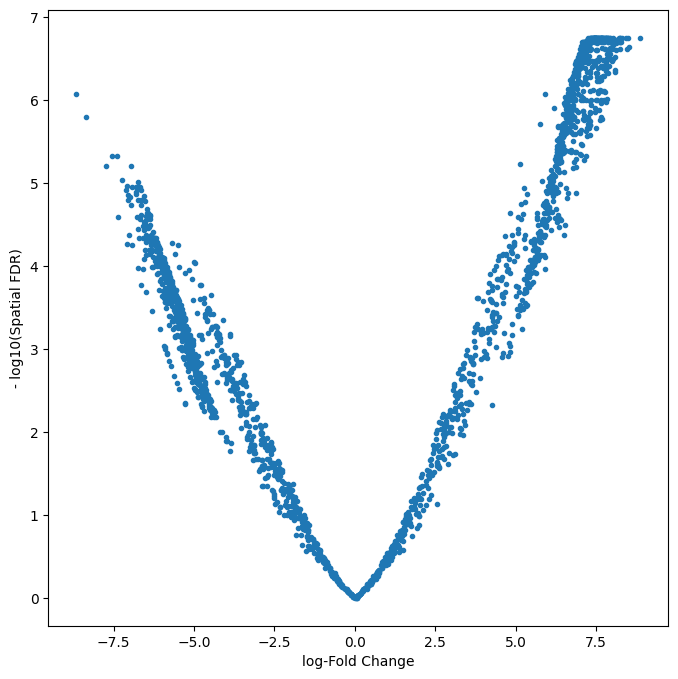

In [25]:
plt.plot(DA_results.logFC, -np.log10(DA_results.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)")

#### Visualizing results from Milo analysis

To visualize DA results and relate them to the single-cell embedding, we build an abstracted graph of connecting neighbourhoods that have cells in common. This is implemented in the `buildNhoodGraph` function (shouldn't be too difficult to do a python implementation of this).

In [26]:
%%R
milo <- buildNhoodGraph(milo)

To visualize the graph, you have again multiple options. The first one is to just use the functionalities implemented in the `miloR` package in another R chunk.

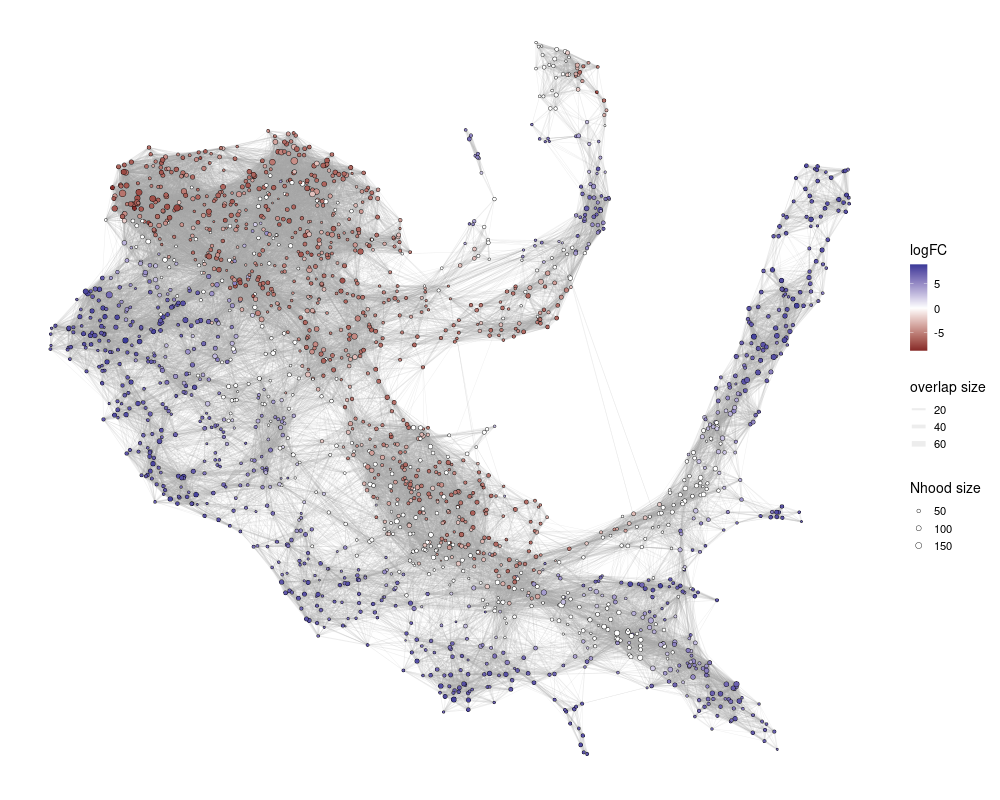

In [27]:
%%R -w 1000 -h 800
plotNhoodGraphDA(milo, DA_results, alpha=0.05)

Otherwise, If you can't take any more R, then you can make an `anndata` object for the neighbourhoods, storing the abstracted graph in the `obsp` slot.

In [28]:
%%R -o nhood_graph
## Save the adjacency matrix of the nhood graph
nhood_graph = as_adjacency_matrix(nhoodGraph(milo), attr="weight")

In [29]:
%%R -o nh_umap_df
## Save the positions in UMAP of nhood indices
nh_umap_df = reducedDim(milo, "UMAP")[unlist(nhoodIndex(milo)),]

In [30]:
nhood_adata = anndata.AnnData(obs = DA_results)

In [31]:
## Add graph
nhood_graph_conn = nhood_graph.copy()
nhood_graph_conn[nhood_graph_conn > 1] = 1 

nhood_adata.uns["neighbors"] = {}
nhood_adata.obsp['distances'] = nhood_graph
nhood_adata.uns['neighbors']["distances"] = nhood_graph
nhood_adata.obsp['connectivities'] = nhood_graph_conn
nhood_adata.uns['neighbors']["connectivities"] = nhood_graph_conn

In [32]:
## Add umap positions
nhood_adata.obsm["X_umap"] = nh_umap_df

Then you can use scanpy functions for visualization (I'm looking into how to fully incorporate the adjacency matrix in the anndata object to add edges in the visualization).

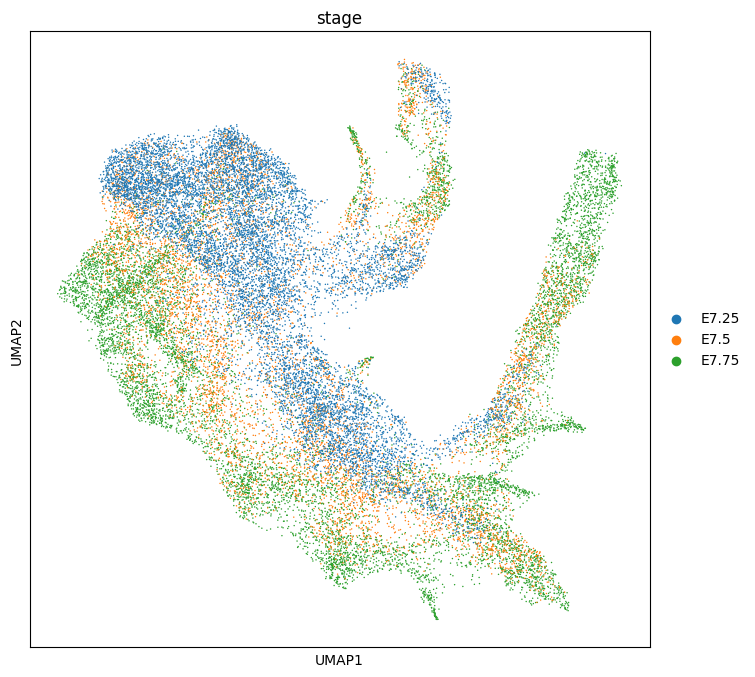

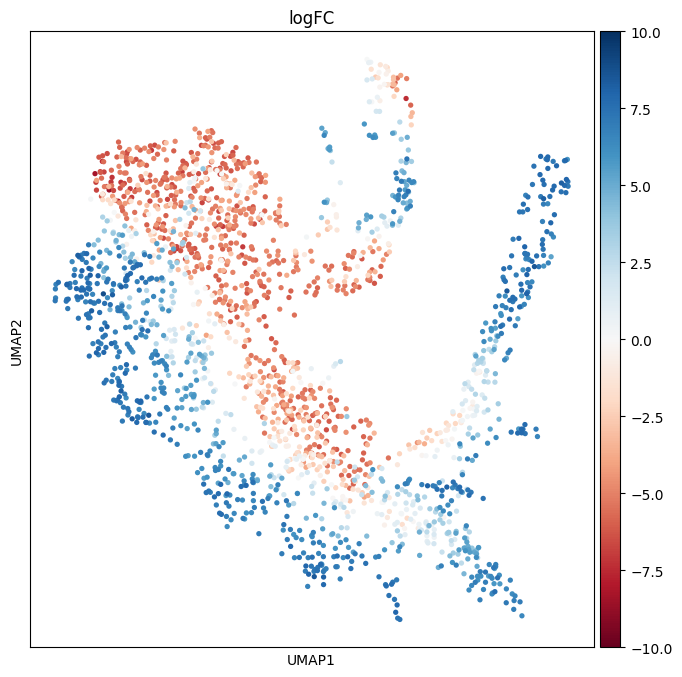

In [33]:
sc.pl.umap(adata, color="stage", vmax=10, vmin=-10)
sc.pl.umap(nhood_adata, color="logFC", cmap='RdBu', vmax=10, vmin=-10)

## More questions?
If you have questions on the R package you can [post an issue](https://github.com/MarioniLab/miloR/issues) on our Github repo.

---

## Session info

In [ ]:
sc.logging.print_versions()